# Outline

- [ Required Packages ](#RP)
- [ Utility Functions ](#UF)
- [ 1 - BBC Bitesize](#1)
  - [ 1.1 - For Individual Topics Quizzes](#1.1)
  - [ 1.2 - For Exam-Style Quizzes](#1.2)
  - [ 1.3 - For Test Questions](#1.3)
- [ 2 - Educationquizzes](#2)
- [ 3 - Primrosekitten](#3)
- [ 4 - Math Quiz](#4)
- [ 5 - Cognitoedu](#5)
- [ 6 - Savemyexams](#6)
- [ Execution ](#E)

Documentation for this notebook can be found here: [Quiz Scraper Notebook Documentation](https://github.com/ThongLai/Learnspot-content-scraping/blob/main/quiz_scraper/quiz_scraper.md)

<a name="RP"></a>
# Required Packages

In [1]:
# Run the following commend if there is a missing package:
# %pip install ipykernel beautifulsoup4 pandas xlsxwriter selenium requests

In [2]:
from bs4 import BeautifulSoup
import pandas as pd
import time
import xlsxwriter
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC


import json
import re
import requests

<a name="UF"></a>
# Utility Functions

In [3]:
def get_urls_from_file(filename='input_urls.txt'):
    urls = []
    
    with open(filename, 'r', encoding='utf-8') as file:
        lines = file.readlines()
    
    # Filter out empty lines
    lines = [line.strip() for line in lines if line.strip()]

    year_group = lines[0].strip()
    subject = lines[1].strip()
    sub_topic = lines[2].strip()
    urls = [line.strip() for line in lines[3:]]

    print(f"[{len(urls)}] Read urls")
    
    return year_group, subject, sub_topic, urls

# Save Json files (For testing/fixing bugs)
def saveJSON(data,name="data.json"):
    with open(name, 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=4)

# Save Soup HTML (For testing/fixing bugs)
def saveSoup(soup,name="soup.html"):
    with open(name, "w") as file:
        file.write(str(soup))

# Save to excel file with Data Validation
def save_excel(output_file, quiz_data):
    difficulty_values = ['easy', 'medium', 'hard']
    question_type_values = ['Multiple_Choice_Question', 
                            'Fill_In_The_Blank',
                            'Multiple_Fill_In_The_Blanks',
                            'Correct_Order_Options',
                            'Image_Question',
                            'True_False',
                            'Multi_Select', 
                            'Short_Question', 
                            'Tap_And_Find']

    df = pd.DataFrame(quiz_data)
    
    with pd.ExcelWriter(output_file) as writer:
        df.to_excel(writer, index=False)
    
        row_num = 1  
        last_row = len(df) + 1

        worksheet = writer.sheets['Sheet1']
        
        # Apply data validation to the 'Difficulty' column
        col_num = df.columns.get_loc('Difficulty')
        worksheet.data_validation(f'${chr(col_num+65)}{row_num}:${chr(col_num+65)}{last_row}', {'validate': 'list', 'source': difficulty_values})
        
        for item in df['Type of question'].unique():
            if item not in question_type_values:
                print(f'**Error: `{item}` Not found in Data Validation list')

        # Apply data validation to the 'Type of question' column
        col_num = df.columns.get_loc('Type of question')
        worksheet.data_validation(f'${chr(col_num+65)}{row_num}:${chr(col_num+65)}{last_row}', {'validate': 'list', 'source': question_type_values})

    print(f"[{len(quiz_data)}] Quiz data has been successfully saved to `{output_file}`.")

# Close Simulation
def close_driver():
    try:
        driver.close()
    except Exception:
        pass

# Open Simulation
def open_driver(hide_simulation=True):
    global driver
    close_driver()
        
    # Create Chrome options
    chrome_options = Options()
    # Add the incognito argument to the Chrome options
    chrome_options.add_argument(f"--incognito {'--headless' if hide_simulation else ''}")
    # Create the WebDriver instance with the Chrome options
    driver = webdriver.Chrome(options=chrome_options)

# Convert into JavaScript array convention
def javascript_array(array):
    return str(array) if len(array) > 1 else "".join(array)

<a name="1"></a>
# BBC Bitesize

<a name="1.1"></a>
### For Individual Topics Quizzes

For <b>BBC</b> links that contains the embeded links format: `https://www.riddle.com/embed/a/[a-zA-Z0-9]*[a-zA-Z]+`<br>
 <div style="text-align: center;">[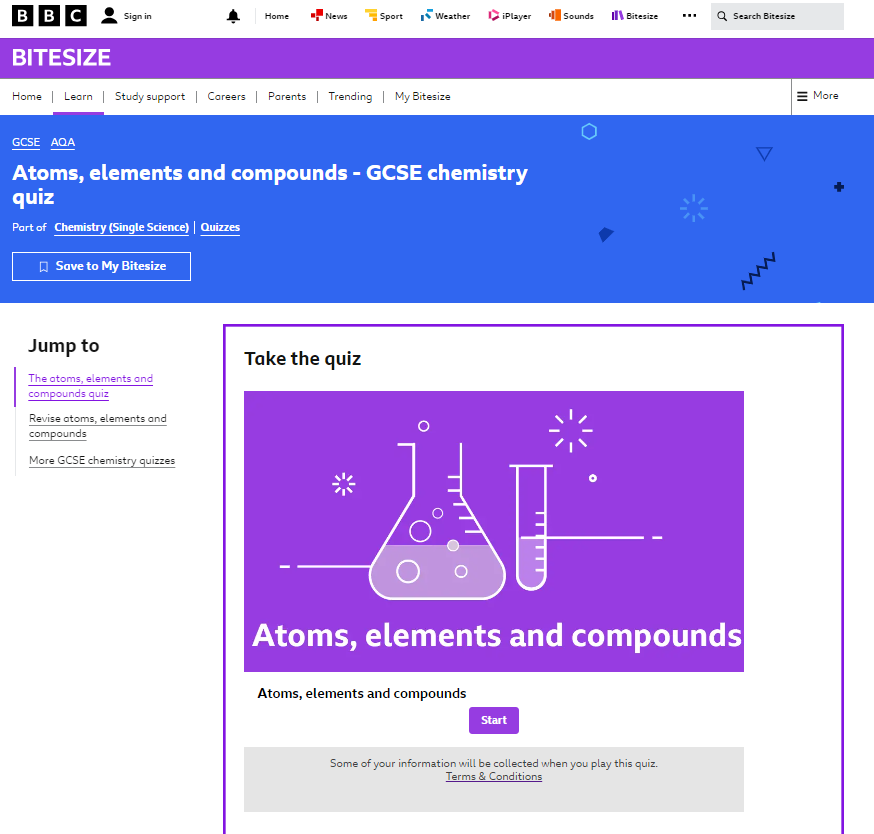<br> Sample Link: `https://www.bbc.co.uk/bitesize/topics/zck96rd/articles/zv7b8p3`](https://www.bbc.co.uk/bitesize/topics/zck96rd/articles/zv7b8p3)</div>

In [4]:
def bbc_simulation(url, embed_urls, quiz_data):
    print(f"Extracting {len(embed_urls)} embed link(s) in:{url}")
    pre_len = len(quiz_data)
    
    # Loop through each URL
    for embed_url in embed_urls:
        # Open the BBC Bitesize quiz page
        driver.get(embed_url)
    
        # Wait for the iframe to load and switch to it
        iframe = WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.TAG_NAME, "iframe"))
        )
        driver.switch_to.frame(iframe)
    
        main_element = driver.find_element(By.XPATH, "//main[@data-block-type='Content']")
        driver.execute_script("arguments[0].scrollIntoView();", main_element)
        
        time.sleep(1)
        
        driver.execute_script("document.body.style.zoom='50%'")
    
        # for i in range(3):
        while True:
            try:
                # Wait for the 'Next' button to be clickable and click it
                next_button = driver.find_elements(By.XPATH, "//button[@data-test='next-btn']")
                if next_button:
                    next_button[0].click()
    
                time.sleep(1)
        
                # Check the type of question
                question_type = driver.find_element(By.XPATH, "//main").get_attribute("data-block-type")
    
                if question_type == 'ResultBuilder':
                    print(f"Quiz completed for embed URL:{embed_url} | Quizzes:{len(quiz_data) - pre_len} | Total:{len(quiz_data)}")
                    break
                elif question_type == "Content":
                    continue
                    
                # Wait for the question title to be present
                question_title_elements = WebDriverWait(driver, 20).until(
                    EC.presence_of_all_elements_located((By.CSS_SELECTOR, ".title"))
                )
                
                # Extract text from both h1 elements
                question_title = "".join([element.text for element in question_title_elements]).replace("\n", ' ')
        
                # Get the image if available
                image_element = driver.find_elements(By.TAG_NAME, "video")
                if not image_element:
                    image_element = driver.find_elements(By.TAG_NAME, "img")
                
                image_url = image_element[0].get_attribute("src") if image_element else ""
        
                options = []
                images = []  # List to store image URLs for each choice
                answers = []
                other_text = ''
    
                # Handle Multiple Choice questions
                if question_type in ["MultipleChoice", "SingleChoice"]:
                    question_type = "Multiple_Choice_Question"
                    choices = driver.find_elements(By.XPATH, "//div[@data-test='choice']")
        
                    for choice in choices:
                        choice_text = choice.find_element(By.CSS_SELECTOR, ".choice-content").text
                        options.append(choice_text)
        
                        # Extract the image URL if available
                        if "choice-media" in choice.get_attribute("innerHTML"):
                            question_type = "Image_Question"
                            image_element = choice.find_element(By.CSS_SELECTOR, ".choice-media img")
                            image_url = image_element.get_attribute("src") if image_element else ""
                            options[-1] = image_url

                    if {option.upper() for option in options} == {'TRUE', 'FALSE'}:
                        question_type = "True_False"
                        
                    if choices:
                        choices[0].click()  # Click the first option
        
                    choose_button = driver.find_elements(By.XPATH, "//button[@data-test='choose-btn']")
                    if choose_button:
                        choose_button[0].click()
    
                    time.sleep(1)
                    
                    for choice in choices:
                        if 'class="icon-quiz-correct"' in choice.get_attribute("innerHTML"):
                            choice_text = choice.find_element(By.CSS_SELECTOR, ".choice-content").text
                            answers.append(choice_text)
                            question_type = "Multi_Select" if len(answers) > 1 else question_type
        
                            # Extract the image URL if available
                            if "choice-media" in choice.get_attribute("innerHTML"):
                                question_type = "Image_Question"
                                image_element = choice.find_element(By.CSS_SELECTOR, ".choice-media img")
                                image_url = image_element.get_attribute("src") if image_element else ""
                                answers[-1] = image_url
        
                # Handle Correct_Order_Options questions
                elif question_type == "Order":
                    question_type = "Correct_Order_Options"
                    order_choices = driver.find_elements(By.XPATH, "//div[@data-test='choice']")
                    options = [choice.text for choice in order_choices]
    
                    choose_button = driver.find_elements(By.XPATH, "//button[@data-test='choose-btn']")
                    if choose_button:
                        choose_button[0].click()
    
                    # In case there's a give up button
                    give_up_button = driver.find_elements(By.XPATH, '//button[@data-test="give-up-btn"]')
                    if give_up_button:
                        give_up_button[0].click()
        
                    time.sleep(3)
        
                elif question_type == "TextEntry":
                    question_type = "Fill_In_The_Blank"
                    # Locate the textarea for user input
                    text_entry_field = driver.find_element(By.XPATH, "//textarea[@data-test='textarea']")
                    
                    # Input the answer (you can replace this with your logic to determine the answer)
                    user_answer = "hi"  # Dummy answer;
                    text_entry_field.send_keys(user_answer)
                
                    # Click the 'Choose' button to submit the answer
                    try:
                        choose_button = driver.find_element(By.XPATH, "//button[@data-test='choose-btn']")
                        choose_button.click()
                    except Exception as e:
                        print("Error clicking choose button:", e)
                        break
    
                    time.sleep(2)
    
                elif question_type == "TapAndFind":
    
                    # Click the 'Canvas' element to submit the answer
                    try:
                        canvas_element = driver.find_element(By.TAG_NAME, "canvas")
                        canvas_element.click()
                    except Exception as e:
                        print("Error clicking canvas:", e)
                        break
    
                    time.sleep(1)
                        
                    give_up_button = driver.find_elements(By.XPATH, '//button[@data-test="give-up-btn"]')
                    if give_up_button:
                        give_up_button[0].click()
                            
                    time.sleep(2)
        
                # Wait for the other_text to load
                answer_explanation = driver.find_elements(By.CSS_SELECTOR, ".block")
                # Extract other_text 
                if answer_explanation:
                    other_text = "".join([p.text for p in answer_explanation[0].find_elements(By.TAG_NAME, "p")]).replace('\n', '')
                
                # Append the data to the list
                quiz_data.append({
                    "Year Group": year_group,
                    "Subject": subject,
                    "Sub-Topic": sub_topic,
                    "Difficulty": "easy",
                    "Type of question": question_type,
                    "Question Title": question_title,
                    "Images": image_url,
                    'Options': javascript_array(options),
                    'Answer': javascript_array(answers),
                    "Source(Internel Use)": "BBC Bitesize",
                    "Mark": 1,
                    "Other Text": other_text,
                })
            except Exception as e:
                print(f"Quiz completed for embed URL:{embed_url}{e} | Quizzes: {len(quiz_data) - pre_len} | Total:{len(quiz_data)}")
                break

<a name="1.2"></a>
### For Exam-Style Quizzes

For <b>BBC</b> links that contains the embeded links format: `https://www.riddle.com/embed/a/[0-9]+`<br>
 <div style="text-align: center;">[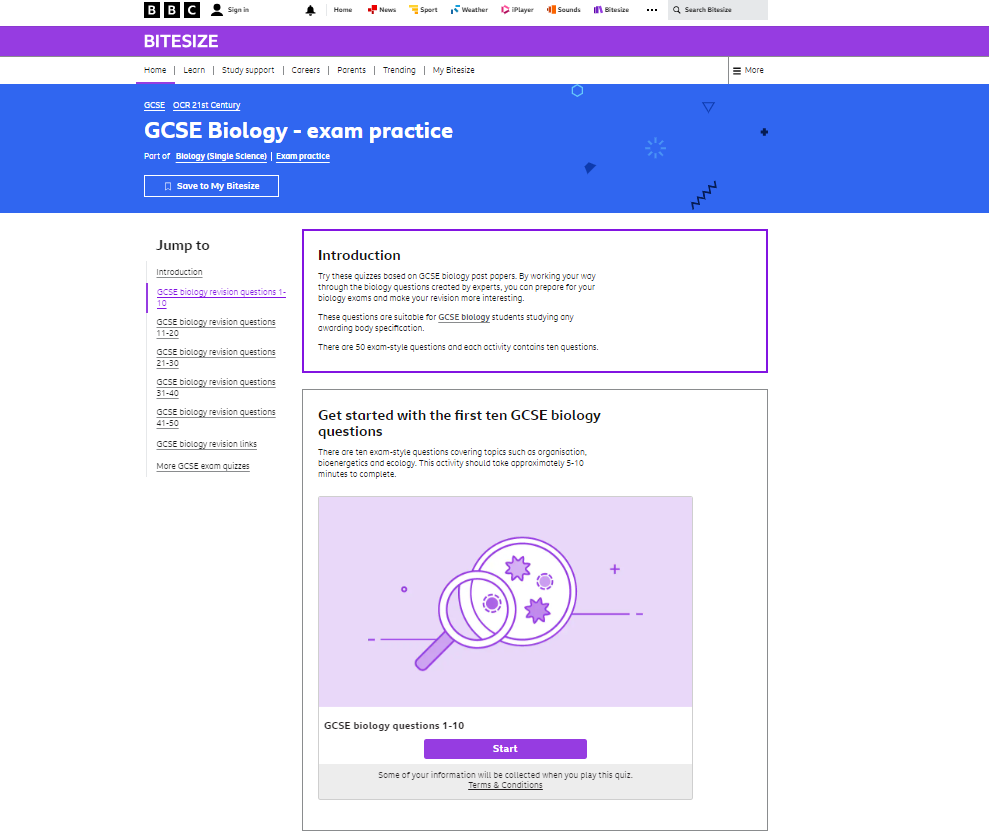<br> Sample Link: `https://www.bbc.co.uk/bitesize/articles/zwdjmbk`](https://www.bbc.co.uk/bitesize/articles/zwdjmbk)</div>

In [5]:
def bbc_exam_style_quizzes(url, embed_urls, quiz_data):
    print(f"Extracting {len(embed_urls)} embed link(s) in:{url}")
    pre_len = len(quiz_data)
    
    # Process each embed URL
    for embed_url in embed_urls:
        embed_response = requests.get(embed_url)

        # Extract the JSON data from the embedded page
        start_index = embed_response.text.find('data:{') + len('data:')
        end_index = embed_response.text.find('},\n', start_index) + 1
        json_data = json.loads(embed_response.text[start_index:end_index])

        # Extract quiz data
        for page_group in json_data['data']['pageGroups']:
            if page_group['templateId'] in ['quiz-question', 'lineup-question']:
                for page in page_group['pages']:
                    question_type = page.get('AnswerMode')
                    question_title = page.get('title_plain', page.get('desc_plain', ''))
                    image = page['image']['original'] if page['image'] else ''

                    # Process 'options', 'answers' differently for each question type
                    if question_type == 'freetext':
                        question_type = 'Fill_In_The_Blank'
                        options = []
                        answers = page.get('textAnswers', page.get('currentTextAnswer', ''))
                    elif page_group['templateId'] == 'quiz-question':
                        question_type = 'Multiple_Choice_Question'
                        options = []
                        answers = []
                        for item in page['allAnswers']:
                            label = item.get('label', '')
                            image_url = item['image']['original'] if item.get('image') else ''
                            
                            options.append(label)
                            if image_url:
                                question_type = 'Image_Question'
                                options[-1] = image_url

                            if {option.upper() for option in options} == {'TRUE', 'FALSE'}:
                                question_type = "True_False"
                                
                            if item.get('isMultiCorrect'):
                                answers.append(label)
                                question_type = "Multi_Select" if len(answers) > 1 else question_type
                                
                                if image_url:
                                    question_type = 'Image_Question'
                                    answers[-1] = image_url
                                    
                        answers = [options[page['answerIndex']]] if page['answerIndex'] >= 0 and page['answerIndex'] < len(options) else answers
                    elif page_group['templateId'] == 'lineup-question':
                        question_type = 'Correct_Order_Options'
                        order_answers = sorted(page['lineupConfig']['listItems'], key=lambda x: x['correctIndex'])
                        options = []
                        answers = []
                        for item in order_answers:
                            answers.append(item['title'])
                            if item.get('image'):
                                answers[-1] = item['image']['original']
                    
                    if not answers:
                        print(' **Empty answer**')
                        
                    other_text = page.get('explanation_plain', '')
                    if not other_text and page.get('CorrectWrongExplanation'):
                        other_text = page['CorrectWrongExplanation']['wrong_plain'].strip("Whoops! ") if page['CorrectWrongExplanation']['enable'] else ''

                    # Construct the new dictionary
                    quiz_data.append({
                        'Year Group': year_group,
                        'Subject': subject,
                        'Sub-Topic': sub_topic,
                        'Difficulty': 'easy',
                        'Type of question': question_type,
                        'Question Title': question_title,
                        'Images': image,
                        'Options': javascript_array(options),
                        'Answer': javascript_array(answers),
                        'Source(Internel Use)': "BBC Bitesize",
                        'Mark': 1,
                        'Other Text': other_text,
                        })
            elif page_group['templateId'] == 'question-bank':
                # Extract the JSON data from the embedded page
                start_index = embed_response.text.find('questionBankData:') + len('questionBankData:')
                end_index = embed_response.text.find('}]', start_index) + 2
                json_data = json.loads(embed_response.text[start_index:end_index])
        
                for item in json_data:
                    question_type = 'Multiple_Choice_Question'
                    question_title = item['question']
                    image = ''
                    options = item['answers']
                    answers = [item['answerCorrectValue']]
                    other_text = item['answerExplanation']

                    # Construct the new dictionary
                    quiz_data.append({
                        'Year Group': year_group,
                        'Subject': subject,
                        'Sub-Topic': sub_topic,
                        'Difficulty': 'easy',
                        'Type of question': question_type,
                        'Question Title': question_title,
                        'Images': image,
                        'Options': javascript_array(options),
                        'Answer': javascript_array(answers),
                        'Source(Internel Use)': "BBC Bitesize",
                        'Mark': 1,
                        'Other Text': other_text,
                    })
        print(f"Quiz completed for embed URL:{embed_url} | Quizzes:{len(quiz_data) - pre_len} | Total:{len(quiz_data)}")

<a name="1.3"></a>
### For Test questions

For <b>BBC</b> links that contains the embeded links format: `https://bitesize.files.bbci.co.uk/acme-quiz/[a-zA-Z0-9-.]+`<br>
 <div style="text-align: center;">[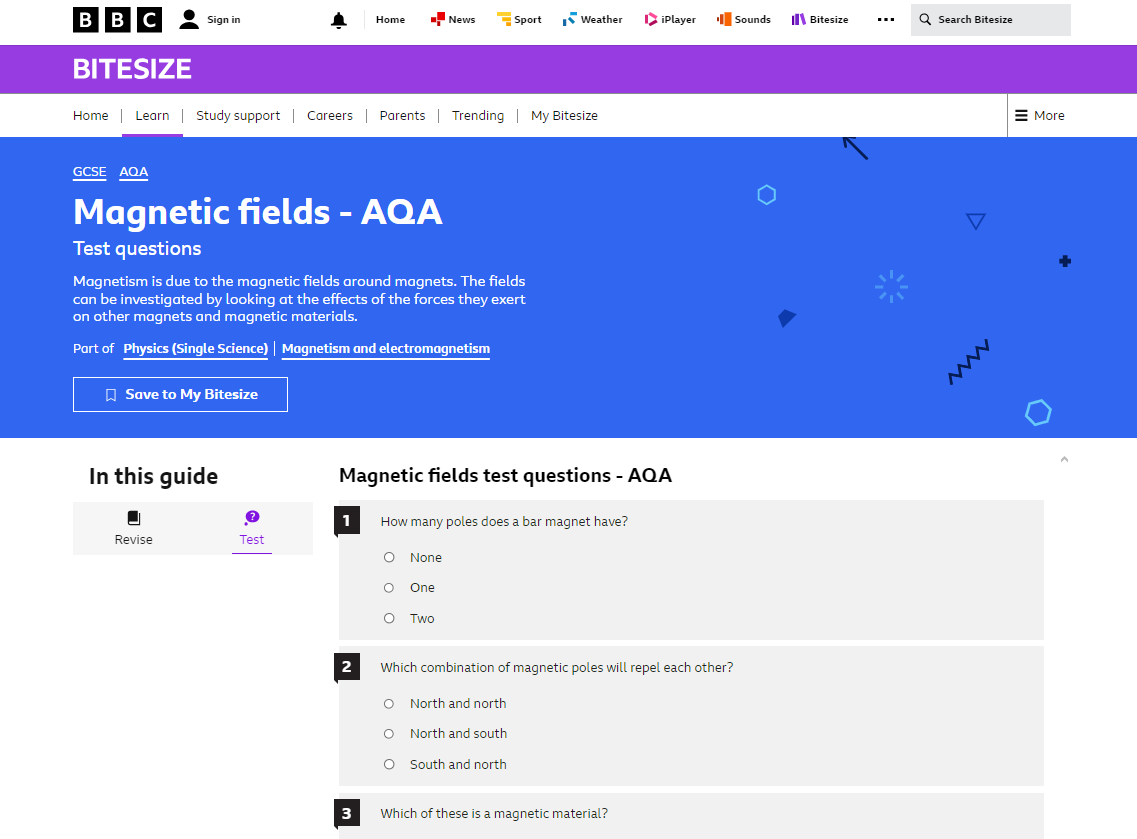<br> Sample Link: `https://www.bbc.co.uk/bitesize/guides/z3s4qhv/test`](https://www.bbc.co.uk/bitesize/guides/z3s4qhv/test)</div>

In [6]:
def bbc_acme_quiz(url, embed_urls, quiz_data):
    print(f"Extracting {len(embed_urls)} embed link(s) in:{url}")
    pre_len = len(quiz_data)
        
    SUPERSCRIPT_MAP = {
        '0': '⁰', '1': '¹', '2': '²', '3': '³', '4': '⁴', '5': '⁵', '6': '⁶',
        '7': '⁷', '8': '⁸', '9': '⁹', 'a': 'ᵃ', 'b': 'ᵇ', 'c': 'ᶜ', 'd': 'ᵈ',
        'e': 'ᵉ', 'f': 'ᶠ', 'g': 'ᵍ', 'h': 'ʰ', 'i': 'ⁱ', 'j': 'ʲ', 'k': 'ᵏ',
        'l': 'ˡ', 'm': 'ᵐ', 'n': 'ⁿ', 'o': 'ᵒ', 'p': 'ᵖ', 'r': 'ʳ', 's': 'ˢ',
        't': 'ᵗ', 'u': 'ᵘ', 'v': 'ᵛ', 'w': 'ʷ', 'x': 'ˣ', 'y': 'ʸ', 'z': 'ᶻ',
        '/': '′',
    }
    
    def extract_text_with_sup(element):
        text_parts = []
        pre_elem_name = None
        for elem in element.descendants:
            if pre_elem_name == 'sup':
                pre_elem_name = elem.name
                continue
                
            if isinstance(elem, str):
                text_parts.append(elem.strip())
            elif elem.name == 'sup':
                text_parts.append(''.join(SUPERSCRIPT_MAP.get(char, char) for char in elem.get_text(strip=True)))
            pre_elem_name = elem.name
        return ''.join(text_parts)

    for embed_url in embed_urls:
        embed_response = requests.get(embed_url)
        soup = BeautifulSoup(embed_response.content, 'html.parser')
        
        start_index = embed_response.text.find('"chapterData":') + len('"chapterData":')
        end_index = embed_response.text.find('}}}', start_index) + 1
        json_data = json.loads(embed_response.text[start_index:end_index])
        
        questions = soup.find_all(class_='question')
    
        for question in questions:
            question_number = question.find(class_='question-number').get_text(strip=True)
    
            # Extract the full question text, including handling <sup> tags for exponents
            question_text = extract_text_with_sup(question.find(class_='question-prompt'))
    
            image_tag = question.find('img')
            image_url = f"{image_tag['srcset']}" if image_tag else None
    
            if 'question--radio' in question['class']:  
                options = question.find_all(class_='radio-answer')
                options = [extract_text_with_sup(opt.find('span')) for opt in options]
            elif 'question--select' in question['class']:
                options = question.find('select').find_all('option')
                options = [opt.get_text(strip=True) for opt in options if opt.get('value') and opt.get('value') != '']
            
            cur_json_data = json_data["questions"][int(question_number) - 1]
            answer = None
            for idx, response in enumerate(cur_json_data["responses"]):
                if response["score"] == "1":
                    answer = options[idx]
    
            quiz_data.append({
                'Year Group': year_group,
                'Subject': subject,
                'Sub-Topic': sub_topic,
                'Difficulty': 'easy',
                'Type of question': 'Multiple_Choice_Question',
                'Question Title': question_text,
                'Images': image_url,
                'Options': javascript_array(options),
                'Answer': javascript_array(answer),
                'Source(Internel Use)': "BBC Bitesize",
                'Mark': 1,
                'Other Text': '',
            })
        print(f"Quiz completed for embed URL:{embed_url} | Quizzes:{len(quiz_data) - pre_len} | Total:{len(quiz_data)}")

### Function to determine different type of BBC Links

In [7]:
# Function to determine different type of BBC Links
def bbc(url, quiz_data):
    simulation_format = "https://www.riddle.com/embed/a/[a-zA-Z0-9]*[a-zA-Z]+"
    exam_style_format = "https://www.riddle.com/embed/a/[0-9]+"
    acme_quiz_format = "https://bitesize.files.bbci.co.uk/acme-quiz/[a-zA-Z0-9-.]+"
    
    response = requests.get(url)
    # Search for "https://www.riddle.com/embed/a/[...]"/"https://bitesize.files.bbci.co.uk/acme-quiz/[...]"
    if re.findall(simulation_format, response.text):
        embed_urls = re.findall(simulation_format, response.text)
        bbc_simulation(url, embed_urls, quiz_data)
        
    elif re.findall(exam_style_format, response.text):
        embed_urls = re.findall(exam_style_format, response.text)
        bbc_exam_style_quizzes(url, embed_urls, quiz_data)
        
    elif re.findall(acme_quiz_format, response.text):
        embed_urls = re.findall(acme_quiz_format, response.text)
        bbc_acme_quiz(url, embed_urls, quiz_data)
    else:
        print(f"No quiz found in {url}")

<a name="2"></a>
# Educationquizzes

For <b>Educationquizzes</b> links format: `educationquizzes.com`<br>
 <div style="text-align: center;">[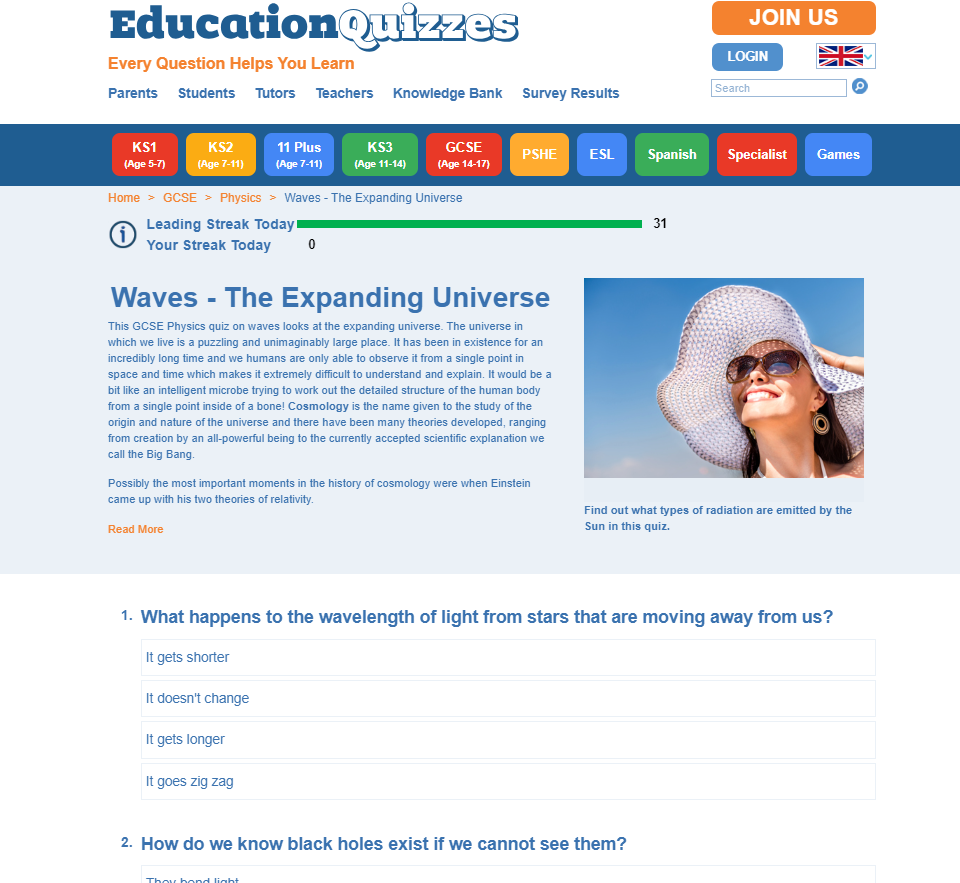<br> Sample Link: `https://www.educationquizzes.com/gcse/physics/waves-the-expanding-universe/`](https://www.educationquizzes.com/gcse/physics/waves-the-expanding-universe/)</div>

In [8]:
def education_quizzes(url, quiz_data):
    head_link = "https://www.educationquizzes.com"
    
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')

    questions = soup.find_all(class_='quiz__question__content')

    print(f"Extracting {len(questions)} quizzes:{url}", end='')
    pre_len = len(quiz_data)
    
    # Loop through each question and extract the required information
    for question in questions:
        question_text = question.find(class_='quiz__question__question')
        question_text = f"{head_link}{question_text.find('img')["src"]}" if question_text.find('img') else question_text.get_text().strip()
        
        image_tag = question.find(class_='quiz__question__image__link')
        image_url = f"{head_link}{image_tag['href']}" if image_tag else None
        
        options = question.find_all(class_='quiz__question__answers__answer')

        answers = next((option for option in options if option['data-iscorrect'] == 'true'), None)
        answers = f"{head_link}{answers.find('img')["src"]}" if answers.find('img') else answers.get_text().strip()

        options = [f"{head_link}{option_text.find('img')["src"]}" if option_text.find('img') else option_text.get_text().strip() for option_text in options]

        other_text = question.find(class_='quiz__question__result__helpful-comment') if question.find(class_='quiz__question__result__helpful-comment') else ''
        if other_text:
            other_text = f"{head_link}{other_text.find('img')["src"]}" if other_text.find('img') else other_text.get_text().strip()
        
        quiz_data.append({
            "Year Group": year_group,
            "Subject": subject,
            "Sub-Topic": sub_topic,
            "Difficulty": "easy",
            "Type of question": "Multiple_Choice_Question",
            "Question Title": question_text,
            "Images": image_url,
            'Options': javascript_array(options),
            'Answer': javascript_array(answers),
            "Source(Internel Use)": "Education Quizzes",
            "Mark": 1,
            "Other Text": other_text,
        })
        
    print(f" | Quizzes:{len(quiz_data) - pre_len} | Total:{len(quiz_data)}")

<a name="3"></a>
# Primrosekitten

For <b>Primrosekitten</b> links format: `primrosekitten.org`<br>
 <div style="text-align: center;">[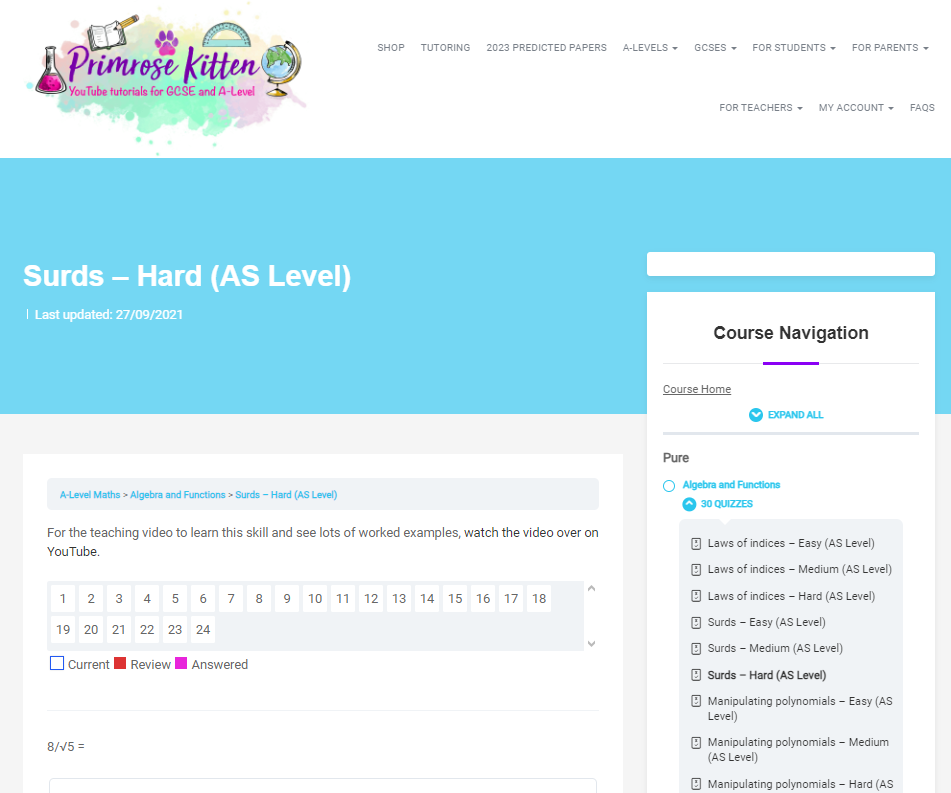<br> Sample Link: `https://primrosekitten.org/courses/a-level-maths/lessons/algebra-and-functions/quizzes/as-level-maths-surds-hard/`](https://primrosekitten.org/courses/a-level-maths/lessons/algebra-and-functions/quizzes/as-level-maths-surds-hard/)</div>

In [9]:
def primrosekitten(url, quiz_data):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')

    # Extracting questions
    questions = soup.find_all(class_='wpProQuiz_listItem')

    print(f"Extracting {len(questions)} quizzes from:{url}", end='')
    pre_len = len(quiz_data)

    # Loop through each question and extract the required information
    for question in questions:
        question_text = question.find(class_='wpProQuiz_question_text').get_text(strip=True)
        image_tag = question.find('img')
        image_url = image_tag['src'] if image_tag else None
        
        options = question.find_all(class_='wpProQuiz_questionListItem')
        options = [option.get_text(strip=True) for option in options]

        # Find the correct answer based on data-pos="0"
        answers = next((option.get_text(strip=True) for option in options if option['data-pos'] == '0'), None)

        # Append the extracted data to quiz_data
        quiz_data.append({
            "Year Group": year_group,  
            "Subject": subject,  
            "Sub-Topic": sub_topic,  # Modify as needed
            "Difficulty": "easy",  # Modify as needed
            "Type of question": "Multiple_Choice_Question",
            "Question Title": question_text,
            "Images": image_url,
            "Options": javascript_array(options),
            "Answer": answers,
            "Source(Internel Use)": "Primrosekitten",
            "Mark": 1,
            "Other Text": "",  # Add any additional text if needed
        })
    
    print(f" | Quizzes: {len(quiz_data) - pre_len} | Total: {len(quiz_data)}")

<a name="4"></a>
# Math Quiz

For <b>Math Quiz</b> links format: `math-quiz.co.uk`<br>
 <div style="text-align: center;">[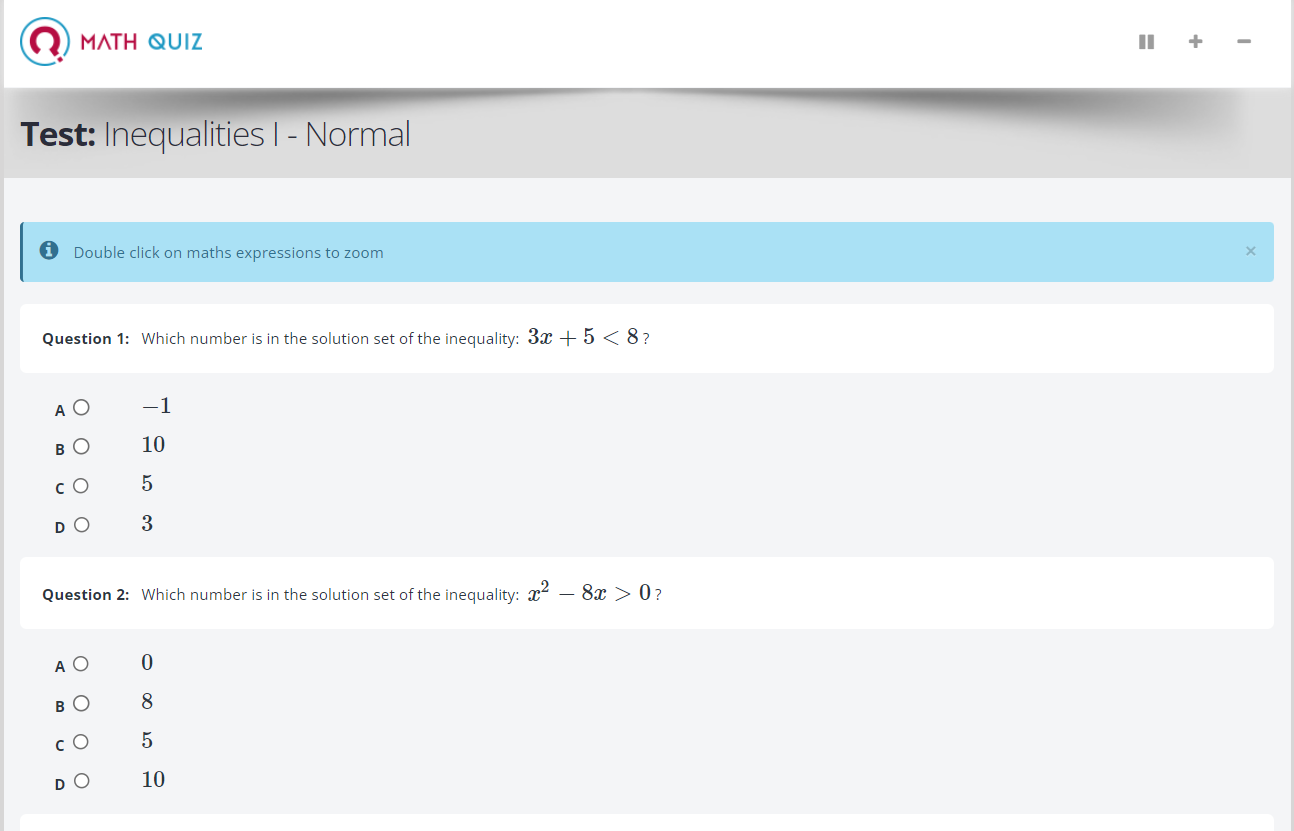<br> Sample Link: `https://math-quiz.co.uk/a-level-maths/algebra/a-level-inequalities-1-easy.html`](https://math-quiz.co.uk/a-level-maths/algebra/a-level-inequalities-1-easy.html)</div>

In [10]:
def math_quiz(url, quiz_data):
    head_link = "https://math-quiz.co.uk/"
    embed_urls = []

    # Extracting `embed_urls`
    if "start_test.php" in url:
        embed_urls += [url]
    else:
        response = requests.get(url)
        # Search for "https://math-quiz.co.uk/start_test.php?id=[...]"
        embed_urls = [f"{head_link}{page}" for page in re.findall(r'start_test.php\?id=[a-zA-Z0-9\-\.]+', response.text)]

    for embed_url in embed_urls:
        response = requests.get(embed_url)
        soup = BeautifulSoup(response.text, 'html.parser')

        # Extracting quizzes
        quizzes = list(soup.find('div', id="maths-test").children)[1::2]

        print(f"Extracting {len(quizzes)} quizzes from:{url}", end='')
        pre_len = len(quiz_data)

        for quiz in quizzes:
            quiz = list(quiz.children)[1::2]
            
            question_title = f"{quiz[0].find('b').next_sibling.strip()} {quiz[0].find('math').decode().replace('\n', '') if quiz[0].find('math') else ''}"

            image_url = f"{head_link}{quiz[0].find('img')['src']}" if quiz[0].find('img') else None

            # Extracting options and correct answer (smallest id value)
            options = []
            correct_answer_idx = 0
            smallest_answer_id = quiz[1].find('input', type='hidden')['value']
            for idx, answer_div in enumerate(quiz[1:]):
                options.append(answer_div.find('math').decode().replace('\n', '') if answer_div.find('math') else '')
                if answer_div.find('img'):
                    options[-1] = f"{head_link}{answer_div.find('img')['src']}"
                                                
                answer_id = answer_div.find('input', type='hidden')['value']
                if smallest_answer_id > answer_id:
                    smallest_answer_id = answer_id
                    correct_answer_idx = idx
    
            answers = options[correct_answer_idx]

            # Append the extracted data to quiz_data
            quiz_data.append({
                "Year Group": year_group,
                "Subject": subject,
                "Sub-Topic": sub_topic,
                "Difficulty": "easy",
                "Type of question": "Multiple_Choice_Question",
                "Question Title": question_title,
                "Images": image_url,
                "Options": javascript_array(options),
                "Answer": answers,
                "Source(Internel Use)": "Math Quiz",  # Modify as needed
                "Mark": 1,
                "Other Text": '',  # Add any additional text if needed
            })

    print(f" | Quizzes: {len(quiz_data) - pre_len} | Total: {len(quiz_data)}")

<a name="5"></a>
# Cognitoedu

For <b>Cognitoedu</b> links format: `cognitoedu.org`<br>
 <div style="text-align: center;">[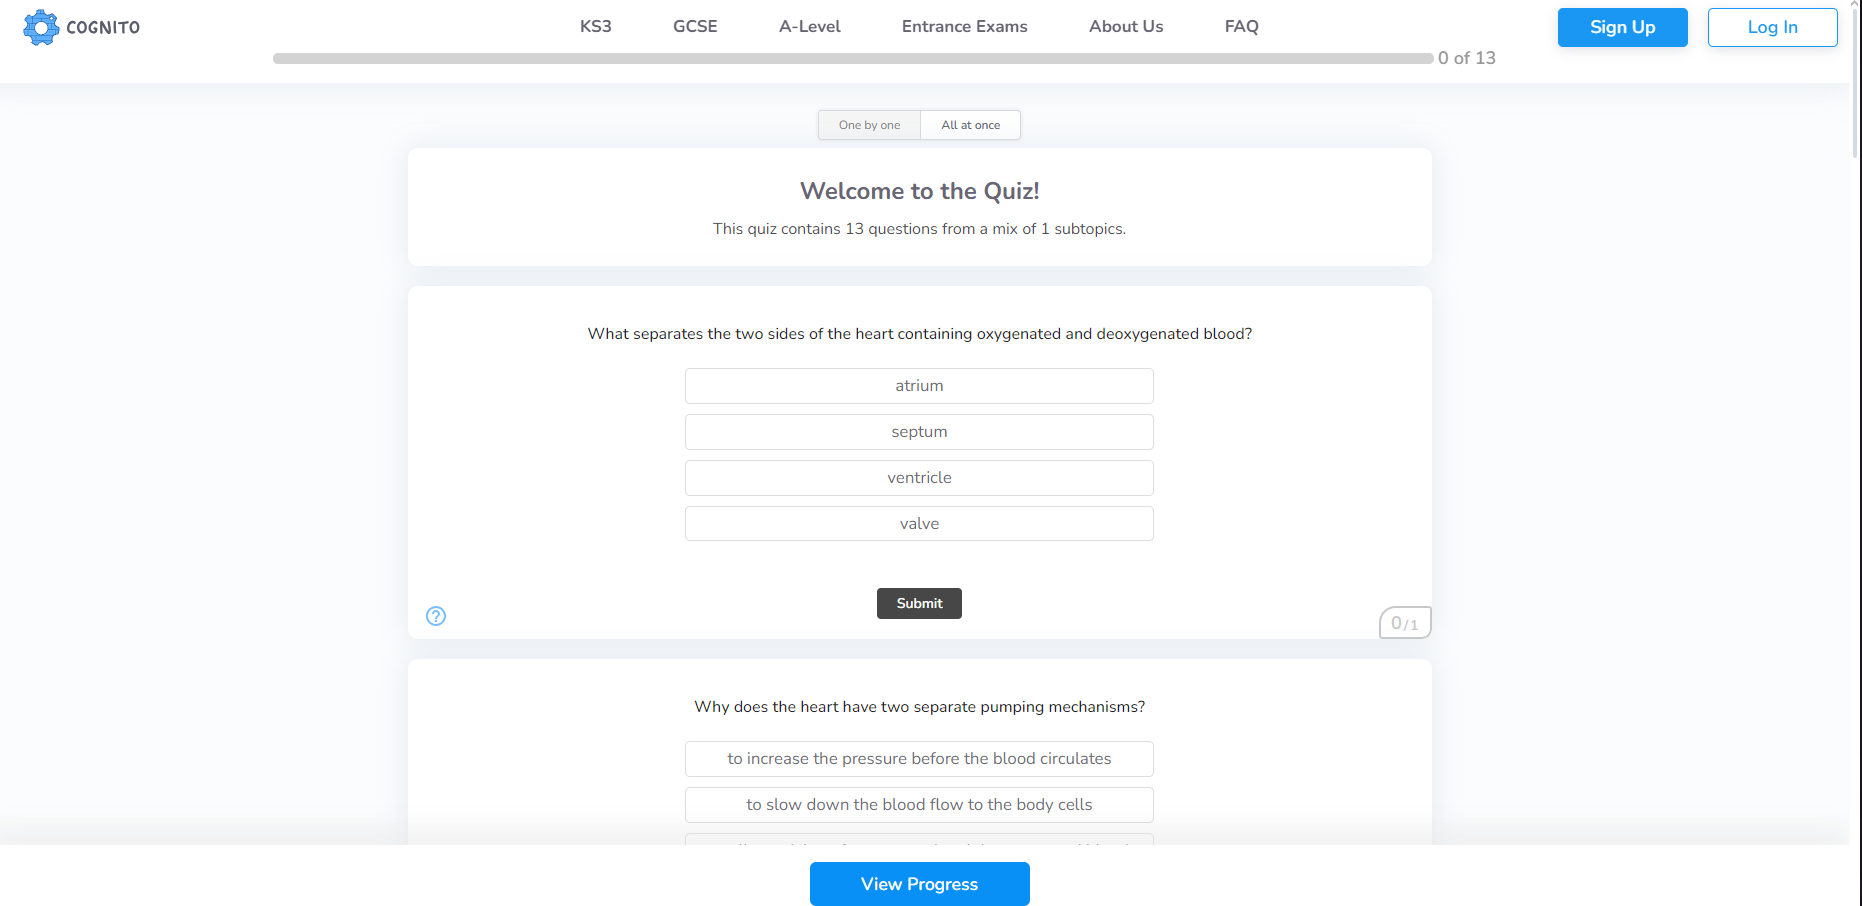<br> Sample Link: `https://cognitoedu.org/courserevise/b3-alevel-aqa/b3-alevel-aqa_ClHRwUVV`](https://cognitoedu.org/courserevise/b3-alevel-aqa/b3-alevel-aqa_ClHRwUVV)</div>

In [11]:
def cognitoedu(url, quiz_data):
    def get_soup_from_simulation():
        driver.get(url)
    
        driver.execute_script("document.body.style.zoom='5%'")
        
        at_at_once_button = WebDriverWait(driver, 10).until(
        EC.element_to_be_clickable((By.XPATH, "//button[.//p[text()='All at once']]")))
        at_at_once_button.click()
        
        buttons = WebDriverWait(driver, 10).until(EC.presence_of_all_elements_located((By.XPATH, "//button[.//p[text()='Submit' or text()='Mark']]")))
    
        for button in buttons:
            try:
                if button.is_enabled():
                    submit_button = WebDriverWait(driver, 10).until(EC.element_to_be_clickable(button))
                    submit_button.click()
            except:
                return False

        try:
            WebDriverWait(driver.find_elements(By.CLASS_NAME, 'jss1410')[-1], 3).until(
                lambda driver: (driver.find_elements(By.CLASS_NAME, 'jss938') or 
                                driver.find_elements(By.CLASS_NAME, 'jss855') or 
                                driver.find_elements(By.CLASS_NAME, 'jss991'))
            )
        except:
            return False
                
        return BeautifulSoup(driver.page_source, 'html.parser')

    
    # Get the page source and parse it with BeautifulSoup
    soup = get_soup_from_simulation()
    while not soup:
        open_driver()
        soup = get_soup_from_simulation()
    
    
    # Extracting quizzes
    quizzes = soup.find_all('div', class_='jss1410')
    
    print(f"Extracting {len(quizzes)} quizzes from:{url}", end='')
    pre_len = len(quiz_data)
    
    for quiz in quizzes:
        if quiz.find('canvas'): # Skipping interaction questions
            continue
            
        question_type = 'Fill_In_The_Blank' if quiz.find(('textarea', 'input')) else 'Multiple_Choice_Question'
        question_title = ' '.join([ques.decode_contents().strip() for ques in quiz.find_all(class_=('mathFieldWrapper', 'ML__base'))[0].find_all('p')])
        
        for hidden in quiz.find_all(class_='jss838'):
            question_title = question_title.replace(hidden.get_text(), '_'*len(hidden.get_text()))

        if not question_title:
            print(' **Empty Question**')
        
        image_url = quiz.find('img')['src'] if quiz.find('img') else None
        
        answers = [quiz.find(class_='jss835').get_text(strip=True)] if quiz.find(class_='jss835') else []
        options = []
        other_text = ''
        
        for idx, answer_div in enumerate(quiz.find_all(class_=('mathFieldWrapper', 'ML__base'))[1:]):
            if answer_div.findParent(class_=('jss855', 'jss991')):
                answers.append(answer_div.decode_contents().strip())
                options.append(answer_div.decode_contents().strip()) if question_type != 'Fill_In_The_Blank' else None
            elif answer_div.findParent(class_='jss851'):
                options.append(answer_div.decode_contents().strip())
            elif idx == len(quiz.find_all(class_=('mathFieldWrapper', 'ML__base'))) - 2:
                other_text = answer_div.decode_contents().strip()
        
        if not answers:
            print(' **Empty answer**')
            
        # Append the extracted data to quiz_data
        quiz_data.append({
            "Year Group": year_group,
            "Subject": subject,
            "Sub-Topic": sub_topic,
            "Difficulty": "easy",
            "Type of question": question_type,
            "Question Title": question_title,
            "Images": image_url,
            "Options": javascript_array(options),
            "Answer": javascript_array(answers),
            "Source(Internel Use)": "Cognitoedu",
            "Mark": 1,
            "Other Text": other_text,
        })
    
    print(f" | Quizzes: {len(quiz_data) - pre_len} | Total: {len(quiz_data)}")

<a name="6"></a>
# Savemyexams

For <b>Savemyexams</b> links format: `savemyexams.com`<br>
 <div style="text-align: center;">[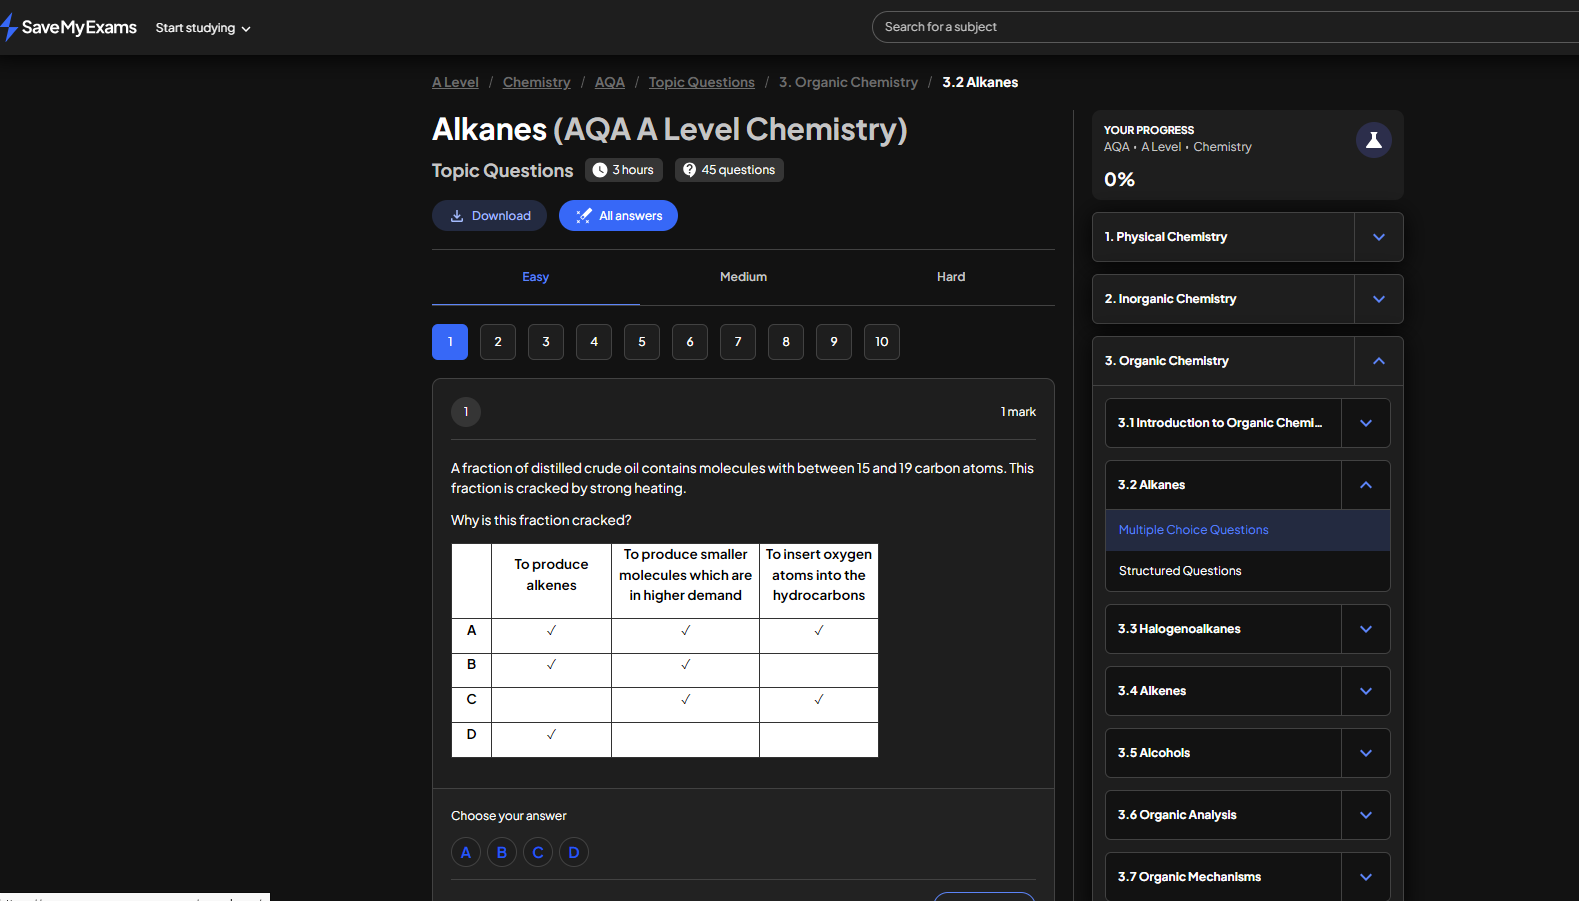<br> Sample Link: `https://www.savemyexams.com/a-level/chemistry/aqa/17/topic-questions/3-organic-chemistry/3-2-alkanes`](https://www.savemyexams.com/a-level/chemistry/aqa/17/topic-questions/3-organic-chemistry/3-2-alkanes)</div>

In [12]:
def savemyexams(url, quiz_data):
    response = requests.get(url)

    # Extract the JSON data from the embedded page
    soup = BeautifulSoup(response.content, 'html.parser')
    json_data = json.loads(soup.find(id='__NEXT_DATA__').decode_contents())

    # Extracting quizzes
    quizzes = [data['pages'] for data in json_data['props']['pageProps']['posts']]
    
    print(f"Extracting {sum(len(level) for quiz in quizzes for level in quiz)} quizzes from:{url}", end='')
    pre_len = len(quiz_data)

    # Extract quiz data
    for quiz in quizzes:
        for quiz_level in quiz:
            for cur_quiz in quiz_level:
                difficulty = cur_quiz['difficulty']
                
                question_type = cur_quiz['type'].upper()
                if question_type != "MCQ":
                    question_type = 'Fill_In_The_Blank'
    
                title = BeautifulSoup(cur_quiz['problem'][0]['body'], 'html.parser')
                
                image_url = ''
                for img_tag in title.find_all('img'):
                    if img_tag['src'][:5] != 'data:':
                        image_url = img_tag['src']
                        img_tag.decompose()
                    
                question_title = title.decode_contents().replace('\n', '')
                
                options = []
                answers = []
                other_text = ''
                if question_type == 'MCQ':
                    for key, value in cur_quiz.items():
                        if 'choice' in key:
                            options.append(BeautifulSoup(value[0]['body']).find('p').decode_contents() if value else key[-1])
                    
                    answers = cur_quiz['choice' + cur_quiz['correctChoice']]
                    answers = cur_quiz['correctChoice'] if not answers else [BeautifulSoup(answers[0]['body']).find('p').decode_contents()]
                    
                    if not answers:
                        print(' **Empty answer**')
    
                    other_text = cur_quiz['solution'][0]['body'].replace('\n', '')
                
                elif question_type == 'Fill_In_The_Blank':
                    answers = [cur_quiz['solution'][0]['body'].replace('\n', '')]
    
                mark = cur_quiz['marks']
        
                # Append the extracted data to quiz_data
                quiz_data.append({
                    "Year Group": year_group,
                    "Subject": subject,
                    "Sub-Topic": sub_topic,
                    "Difficulty": difficulty,
                    "Type of question": question_type,
                    "Question Title": question_title,
                    "Images": image_url,
                    "Options": javascript_array(options),
                    "Answer": javascript_array(answers),
                    "Source(Internel Use)": "Savemyexams",
                    "Mark": mark,
                    "Other Text": other_text,
                })
    
    print(f" | Quizzes: {len(quiz_data) - pre_len} | Total: {len(quiz_data)}")

# TESTING/FIXING BUGS SPACE

In [13]:
urls = [
    # "https://www.bbc.co.uk/bitesize/topics/zt36g2p/articles/zxvxwnb",
    # "https://www.bbc.co.uk/bitesize/topics/znm96rd/articles/z4qvn9q",
    # "https://www.bbc.co.uk/bitesize/topics/zpxktcw/articles/zrkw2fr", #**Empty answer**
    # "https://www.bbc.co.uk/bitesize/topics/z9r4jxs/articles/zqpv7p3", #**KeyError: 'original'**
    # "https://math-quiz.co.uk/a-level-maths/algebra/algebraic-expressions-1-medium.html",
    # "https://math-quiz.co.uk/a-level-maths/algebra/a-level-inequalities-1-easy.html", #**options error** 
    # "https://cognitoedu.org/courserevise/b3-alevel-aqa/b3-alevel-aqa_rYodvOUG",
    # "https://cognitoedu.org/courserevise/b3-alevel-aqa/b3-alevel-aqa_AHPtLiUc", #**Text Entry qquestion_title error**
    # "https://www.savemyexams.com/a-level/chemistry/aqa/17/topic-questions/1-physical-chemistry/1-9-oxidation-reduction--redox-equations/multiple-choice-questions/", # **image_url error**
    # "https://www.savemyexams.com/a-level/chemistry/aqa/17/topic-questions/3-organic-chemistry/3-2-alkanes/multiple-choice-questions/", #**Image not found**
    # "https://cognitoedu.org/courserevise/c3-alevel-aqa/c3-alevel-aqa_kgsFAekn" #**Empty answer**
    # "https://cognitoedu.org/courserevise/c3-alevel-aqa/c3-alevel-aqa_reBfxags" #**Empty question**
    # "https://www.savemyexams.com/a-level/physics/aqa/17/topic-questions/1-measurements--their-errors/1-1-use-of-si-units--their-prefixes/structured-questions/#", # **Error correctChoice**
    # "https://cognitoedu.org/courserevise/p3-alevel-aqa/p3-alevel-aqa_KtHnBCAs", #**
    # "https://www.educationquizzes.com/ks1/english/comprehension-a-letter-to-the-queen-summer-of-year-1/",
    "https://www.bbc.co.uk/bitesize/topics/zt36g2p/articles/zdjtjsg" # List index of `options` out of range
]

url = urls[0]
quiz_data = []

<a name="E"></a>
# Execution

In [14]:
# Extract quizzes base on the sources
def extract_quizzes(urls, quiz_data, hide_simulation=True):
    print(f'{year_group} - {subject} - {sub_topic}')

    open_driver(hide_simulation)
    for idx, url in enumerate(urls):
        print(f"{idx+1}) ", end='')
        if "bbc.co.uk" in url:
            bbc(url, quiz_data)
        elif "educationquizzes.com" in url:
            education_quizzes(url, quiz_data)
        elif "primrosekitten.org" in url:
            primrosekitten(url, quiz_data)
        elif "math-quiz.co.uk" in url:
            math_quiz(url, quiz_data)
        elif "cognitoedu.org" in url:
            cognitoedu(url, quiz_data)
        elif "savemyexams.com" in url:
            savemyexams(url, quiz_data)
        else:
            print(f" **Error: Did not find any source for {url}")
    
    close_driver()

In [15]:
year_group, subject, sub_topic, urls = get_urls_from_file()
quiz_data = []

extract_quizzes(urls, quiz_data)

output_file = f"{sub_topic.lower()} {year_group.lower()} {subject.lower()}.xlsx"
save_excel(output_file, quiz_data)

[48] Read urls
KS3 - Maths - Geometry
1) Extracting 1 embed link(s) in:https://www.bbc.co.uk/bitesize/topics/zrf3cdm/articles/zj82h4j
Quiz completed for embed URL:https://www.riddle.com/embed/a/462648 | Quizzes:10 | Total:10
2) Extracting 1 embed link(s) in:https://www.bbc.co.uk/bitesize/topics/zrf3cdm/articles/zqwxnk7
Quiz completed for embed URL:https://www.riddle.com/embed/a/463618 | Quizzes:10 | Total:20
3) Extracting 1 embed link(s) in:https://www.bbc.co.uk/bitesize/topics/zrf3cdm/articles/zc4pk2p
Quiz completed for embed URL:https://www.riddle.com/embed/a/456902 | Quizzes:10 | Total:30
4) Extracting 1 embed link(s) in:https://www.bbc.co.uk/bitesize/topics/zrf3cdm/articles/zgkh97h
Quiz completed for embed URL:https://www.riddle.com/embed/a/460358 | Quizzes:10 | Total:40
5) Extracting 1 embed link(s) in:https://www.bbc.co.uk/bitesize/topics/zrf3cdm/articles/z37vqhv
Quiz completed for embed URL:https://www.riddle.com/embed/a/458678 | Quizzes:10 | Total:50
6) Extracting 1 embed link(